# California Housing Price Dataset (pg. 160)

In [1]:
import keras
import numpy as np
import pandas as pd

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = (
    keras.datasets.california_housing.load_data(version="small")
)

480 rows with 8 features each

In [3]:
X_train_full.shape

(480, 8)

Do feature-wise normalization, by subtraction the mean of the feature and divide by the standard deviation. This resuls in features centered around 0 and as a standard deviation of 1.

In [4]:
# Axis = 0 will calcuate the mean across each column
mean = X_train_full.mean(axis=0)
mean

array([-122.23098  ,   37.807056 ,   44.429165 , 1976.0708   ,
        421.8125   ,  994.6646   ,  397.75     ,    3.5265813],
      dtype=float32)

In [5]:
std = X_train_full.std(axis=0)
std

array([5.1194776e-02, 4.8341740e-02, 9.6651878e+00, 1.4763470e+03,
       3.1940192e+02, 6.6303387e+02, 2.9891754e+02, 1.9816692e+00],
      dtype=float32)

In [6]:
X_train_full_normalized = (X_train_full - mean) / std

First Feature Normalized = First Feature - mean(First Feature) / std(First Feature)

Example:

(-1.2224e+02 - (-122.23098)) / 5.1194776e-02

\= 0.00901999999 / 5.1194776e-02

$\approx$ -0.17618985187

In [7]:
X_train_full[0]

array([-1.2224e+02,  3.7730e+01,  2.1000e+01,  7.0310e+03,  1.2490e+03,
        2.9300e+03,  1.2350e+03,  4.5213e+00], dtype=float32)

In [8]:
X_train_full_normalized[0]

array([-0.1761497, -1.5940031, -2.4240775,  3.4239438,  2.5898013,
        2.9189088,  2.8009396,  0.5019599], dtype=float32)

Should normalize the test data using the mean and standard deviation of the training set. Should never use in the workflow any quantity computed on the test data (leakage).

In [9]:
X_test_normalized = (X_test - mean) / std

Should also scale the targets. Model weights are initialized to be very small values, a large output will require large weights, which will take a very long time to train with a low learning rate.

In [10]:
y_train_full_scaled = y_train_full / 100000
y_test_scaled = y_test / 100000

In [11]:
def get_model():
    model = keras.Sequential(
        [
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(64, activation="relu"),
            # Single unit with no activation
            # Typical setup for scalar regression
            # (trying to predict a single continuous value)
            keras.layers.Dense(1),
        ]
    )

    model.compile(
        optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"]
    )

    return model

## K-Fold Validation

There are a limited number of data points (480), so scores from evaluating from a validation set would change a lot depending on which data points are selected in the validation set. This would prevent us from reliably evaluating the model.

Best practice is K-fold cross-validation, which consists of splitting the available data into K partitions (typically K = 4 ot 5), instantiating K identical models, then training each on K - 1 partitions while evaluating on the remaining partition.

The validation score is the average of the K validation scores.

In [12]:
k = 4

# Since no need to split validation set, rename vars
X_train_normalized = X_train_full_normalized
y_train_scaled = y_train_full_scaled

# Each fold will have 480 // 4 = 120 samples
num_val_samples = len(X_train_full) // k
num_epochs = 50

all_scores = []

# Loop through each fold
for i in range(k):
    print(f"Processing fold #{i + 1}")

    # Get the k-th fold for validation
    fold_x_val = X_train_normalized[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train_scaled[i * num_val_samples : (i + 1) * num_val_samples]

    # For training, get the other folds
    fold_x_train = np.concatenate(
        [
            # Get up to the k-th fold
            X_train_normalized[: i * num_val_samples],
            # Get everything from the (k + 1)-th fold to the end
            X_train_normalized[(i + 1) * num_val_samples :],
        ],
        axis=0,
    )

    fold_y_train = np.concatenate(
        [
            # Get up to the k-th fold
            y_train_scaled[: i * num_val_samples],
            # Get everything from the (k + 1)-th fold to the end
            y_train_scaled[(i + 1) * num_val_samples :],
        ],
        axis=0,
    )

    model = get_model()
    model.fit(fold_x_train, fold_y_train, epochs=num_epochs, batch_size=16, verbose=0)

    scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
    val_loss, val_mae = scores

    all_scores.append(val_mae)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [13]:
all_scores

[0.30062949657440186,
 0.31154587864875793,
 0.2339421808719635,
 0.30742618441581726]

In [14]:
[round(value, 3) for value in all_scores]

[0.301, 0.312, 0.234, 0.307]

In [15]:
round(np.mean(all_scores), 3)

np.float64(0.288)

Try training with 200 epochs

In [16]:
k = 4

# Each fold will have 480 // 4 = 120 samples
num_val_samples = len(X_train_full) // k
num_epochs = 200

all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i + 1}")

    # Get the k-th fold for validation
    fold_x_val = X_train_normalized[i * num_val_samples : (i + 1) * num_val_samples]
    fold_y_val = y_train_scaled[i * num_val_samples : (i + 1) * num_val_samples]

    # For training, get the other folds
    fold_x_train = np.concatenate(
        [
            # Get up to the k-th fold
            X_train_normalized[: i * num_val_samples],
            # Get everything from the (k + 1)-th fold to the end
            X_train_normalized[(i + 1) * num_val_samples :],
        ],
        axis=0,
    )

    fold_y_train = np.concatenate(
        [
            # Get up to the k-th fold
            y_train_scaled[: i * num_val_samples],
            # Get everything from the (k + 1)-th fold to the end
            y_train_scaled[(i + 1) * num_val_samples :],
        ],
        axis=0,
    )

    model = get_model()
    history = model.fit(
        fold_x_train,
        fold_y_train,
        validation_data=(fold_x_val, fold_y_val),
        epochs=num_epochs,
        batch_size=16,
        verbose=0,
    )

    mae_history = history.history["val_mean_absolute_error"]
    all_mae_histories.append(mae_history)

Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


Each list in `all_mae_histories` has 200 MAE values (for each epoch)

In [17]:
len(all_mae_histories[0])

200

In [18]:
# Get the average MAE for each epoch
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

In [19]:
df = pd.DataFrame({"Epochs": range(1, 201), "Validation MAE": average_mae_history})

<Axes: xlabel='Epochs', ylabel='Validation MAE'>

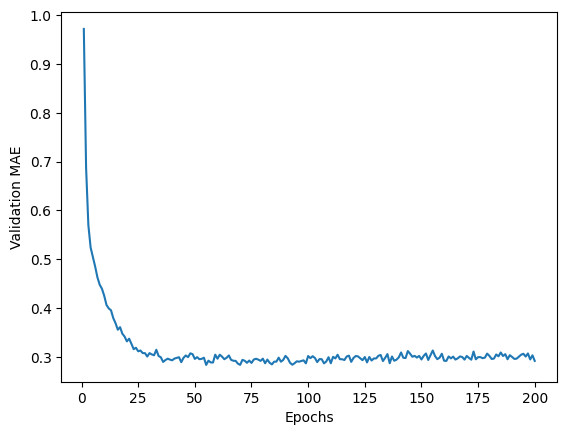

In [20]:
df.plot(x="Epochs", y="Validation MAE", ylabel="Validation MAE", legend=False)

Omit the first 10 validation MAEs because it's causing the scaling to be weird

<Axes: xlabel='Epochs', ylabel='Validation MAE'>

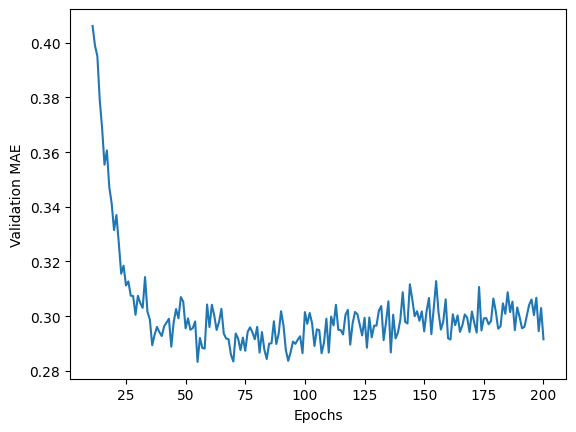

In [21]:
df.loc[10:, :].plot(
    x="Epochs", y="Validation MAE", ylabel="Validation MAE", legend=False
)

MAE stops improving after around 120-140 epochs. Can fit a final model with 130 epochs.

In [23]:
model = get_model()
model.fit(
    X_train_full_normalized,
    y_train_full_scaled,
    epochs=130,
    batch_size=16,
    verbose=0,
)

In [24]:
test_mean_squared_error, test_mean_absolute_error = model.evaluate(
    X_test_normalized, y_test_scaled
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3067 - mean_absolute_error: 0.3227 


In [25]:
test_mean_squared_error

0.28271105885505676

In [26]:
test_mean_absolute_error

0.3033059239387512

Still off by about $30,000 on average.